# Optimizing Travel-time Matrix Model

The problem we would like to address here is the following. We have a list of attractions in San Francisco and we would like to know the travel times between any given pair.  We can use the Google API to find average travel times, but this is expensive.   We would like to see if we can build a good model of the travel-time matrix such that we can avoid making so many queries in the future.  For the purpose of this investigation, we will just use a previously obtained travel-time matrix to build our model and see what the minmal required amount of data is.  

Secondly, we would like to see if the knoweldge gradient policy can be used to make queries more efficient in the first place.  For the moment, the conclusions I am reaching are the following:

1. A fairly good model of the distance matrix may be achieved with only a few thousand queries.

2.  SigOpt vastly improves the time needed to find this optimal model relative to standard grid-search.  (For the particular dataset, model and search parameters used here the two methods did yield similar r-squared values, however.)

3.  The knoweldge-gradient (KG) motivated query does not outperform a completely random query of the distance matrix.  (Our performance metrix is r-squared for the model built from the queried data, not optimizing a single route, in which case the KG policy is better.  Our goal, however, is to have a robust dataset which can be used to optimize ANY route in the future.)

This note is organized as follows.  First, we download the necessary packages and data in Section I.  In Section II we will first build some models the ol' fashioned way, i.e, grid-search.  These models will take in two coordinates (lattiude, longitude) associated with our list of attractions and predict a travel time after training on the Google API results.  In Section III we will then compare the grid-search results with the SigOpt method.  Finally, in Section IV we will run some (very rudimentary) test on querying with a KG policy.  

## I. Import pacakges and build dataset.

In [89]:
import pickle as pkl
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNet, BayesianRidge
import random
import math
import time
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
from sigopt import Connection

# API Token
conn = Connection(client_token="QUIRZXPKOTDLYPQFVKRYMHYIEHUVZQRDGCMWPXQSOLHTNMXA") 

# Dev Token
# conn=Connection(client_token="EHKXUETTTHBUKXVPQKGTKKQYTWJYMCJIIISTGKSGJAPCYOXX")

Next we import the data already requested from the Google API and build our dataset.

In [8]:
travel_times=pkl.load(open('/Users/williamcottrell72/MyGit/TravelApp/good_data/San_Francisco/travel_times.pkl','rb'))
site_index=pkl.load(open('/Users/williamcottrell72/MyGit/TravelApp/good_data/San_Francisco/site_index.pkl','rb'))
final_attractions=pkl.load(open('/Users/williamcottrell72/MyGit/TravelApp/good_data/San_Francisco/final_attractions_dict.pkl','rb'))

coords={}
for x in list(final_attractions.keys()):
    coords[x]=final_attractions[x][0]['geometry']['location']
    
    
def make_data(site_index,coords):
    X=[]
    Y=[]
    for i in range(len(site_index)):
        for j in range(len(site_index)):
            origin=site_index[i]
            destination=site_index[j]
            var=np.array([coords[origin]['lat'],coords[origin]['lng'],coords[destination]['lat'],coords[destination]['lng']])
            X.append(var)
            Y.append(travel_times[i,j])
    return np.vstack(X),np.array(Y)

X,Y = make_data(site_index,coords)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    

## II. Learning the Ol' Fashioned Way

In [5]:
from sklearn.model_selection import GridSearchCV

The data we are given consists of lattitude and longitude values in degrees.  It is helpful to have a function which converts these spherical coordinates to an actual distance (arc-length on sphere).  Directly including the distance as a feature in our model can help us find an optimized model more quickly, since we naturally expect that the travel times correlate strongly with distance.

In [6]:
def make_distance(X_train):
    p1=X_train[:,:2]
    p2=X_train[:,2:]
    x1=np.cos(p1[:,0]*math.pi/180)*np.cos(p1[:,1]*math.pi/180)
    x2=np.cos(p2[:,0]*math.pi/180)*np.cos(p2[:,1]*math.pi/180)
    y1=np.cos(p1[:,0]*math.pi/180)*np.sin(p1[:,1]*math.pi/180)
    y2=np.cos(p2[:,0]*math.pi/180)*np.sin(p2[:,1]*math.pi/180)
    z1=np.sin(p1[:,0]*math.pi/180)
    z2=np.sin(p2[:,0]*math.pi/180)
    dot=x1*x2+y1*y2+z1*z2
    distance=3959*np.arccos(dot) 
#   The factor above accounts for the radius of the earth in miles
    return distance

Next we compute distances between all pairs of points.  The arcos function occasionally returns a NaN since the dot-product is occasionally greater than one due to numerical error.  We remove these elemetns by creating a mask.

In [11]:
distance=make_distance(X)
mask=~np.isnan(distance)
X2=np.concatenate((X,distance.reshape((len(X),-1))),axis=1)

train_distance=make_distance(X_train)
test_distance=make_distance(X_test)
train_mask=~np.isnan(train_distance)
test_mask=~np.isnan(test_distance)

X_train2=np.concatenate((X_train,train_distance.reshape((len(X_train),-1))),axis=1)
X_test2=np.concatenate((X_test,test_distance.reshape((len(X_test),-1))),axis=1)

/Users/williamcottrell72/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in arccos
  # This is added back by InteractiveShellApp.init_path()


Now let's see how a few different models do in predicting the data.  (I tried some other models as well; these are just representative.)

### Random Forest

In [12]:
param_grid={"max_features":['sqrt'],"max_depth":[3,4,5,10,20],"criterion":['mse']}
rf=RandomForestRegressor()

In [39]:
gscv=GridSearchCV(rf,param_grid,scoring='r2',cv=10)
gscv.fit(X_train[train_mask],Y_train[train_mask])

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_features': ['sqrt'], 'max_depth': [3, 4, 5, 10, 20], 'criterion': ['mse']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

In [33]:
gscv.best_score_

0.9522641293041266

In [34]:
gscv.best_params_

{'criterion': 'mse', 'max_depth': 20, 'max_features': 'sqrt'}

This score was pretty good, but we can maybe do better if we include the distance explicitly as a feature. Let's see: 

In [44]:
gscv_distance=GridSearchCV(rf,param_grid,scoring='r2',cv=10)
gscv_distance.fit(X_train2[train_mask],Y_train[train_mask])

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_features': ['sqrt'], 'max_depth': [3, 4, 5, 10, 20], 'criterion': ['mse']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

In [36]:
gscv_distance.best_score_

0.9579188069525626

In [37]:
gscv_distance.best_params_

{'criterion': 'mse', 'max_depth': 20, 'max_features': 'sqrt'}

Indeed, the score was better.  However, so far this was all GSCV on the training data.  As we can see, it helped (though not much) to include the distance explicitly as a feature.  Let's see how we did on the test set.  

In [45]:
def rmse(X,Y,model):
    Y_predict=model.predict(X)
    mse=sum(((Y-Y_predict)**(2))/len(X))
    return mse**.5

def rsquared(X,Y,model):
    Y_predict=model.predict(X)
    mean=np.mean(Y_predict)
    Y_mean=np.array([mean for _ in range(len(Y))])
    return 1-rmse(X,Y,model)**2/((sum(Y-Y_mean)**2)/len(X))

rmse(X_test[test_mask],Y_test[test_mask],gscv), rsquared(X_test[test_mask],Y_test[test_mask],gscv)

(1.736335145334208, 0.9017578795759421)

In [47]:
rmse(X_test2[test_mask],Y_test[test_mask],gscv_distance), rsquared(X_test2[test_mask],Y_test[test_mask],gscv_distance)

(1.6640942179595257, -0.8323942675954417)

Ok, we see that NOT including the distance as a feature wins hands down on the test set.  We therefore prefer the 'gscv' model without the distance.  The reason for this is obvious in retrospect.  Using the distance instead of one of the other coordinates means that there are actually three possible points on the map for any pair of coordinates.  (Given a point, a radius, and a line of lattiude there are two intersections, hence, three points altogether.) . Thus, we can't actually uniquely construct the points from this data X_train2.  The model gscv_distance therefore is not really learning about the regions in space as it should, it muddles different regions.  We could include redundant data (distance and both lat, lng's) but the simpler model 'gscv' is already doing pretty well.  For the simpler model, the rmse is in minutes, so this corresponds to an error of about 1.7 minutes on the test set.  

### Gradient Boosting

Let's try gradient boosting and see if we get anything better.  I'm using a subset of the data on account of how slow the training is for this model.  (Not sure why that is....)

In [49]:
gbr_param_grid={"learning_rate":[.1,.01],"n_estimators":[10],"criterion":["friedman_mse","mae"],"min_samples_split":[3,4],"max_depth":[3,10]}
gbr=GradientBoostingRegressor()
gbr_gscv=GridSearchCV(gbr,gbr_param_grid,scoring='r2',cv=5)
gbr_gscv.fit(X_train[train_mask][:10000],Y_train[train_mask][:10000])

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.1, 0.01], 'n_estimators': [10], 'criterion': ['friedman_mse', 'mae'], 'min_samples_split': [3, 4], 'max_depth': [3, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

In [33]:
gbr_gscv.best_score_

0.7804515299271408

Meh.  Looks like we should stick with random forest.

### ElasticNet

Just as a baseline, let's see how ElasticNet does when trained only on the distance.

In [53]:
elasticnet_param_grid={"alpha":[.001,.01,.1,10],"l1_ratio":[.1,.5,.9]}
elasticnet=ElasticNet()

In [54]:
elasticnet_gscv=GridSearchCV(elasticnet,elasticnet_param_grid,cv=5,scoring='r2')

In [57]:
elasticnet_gscv.fit(train_distance[train_mask].reshape(-1,1),Y_train[train_mask])

GridSearchCV(cv=5, error_score='raise',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [0.001, 0.01, 0.1, 10], 'l1_ratio': [0.1, 0.5, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

In [58]:
elasticnet_gscv.best_score_

0.562055450289036

This is not so bad as a baseline.  It is also useful to know the average speed:

In [82]:
coef=(elasticnet_gscv.predict(np.array([100000]).reshape(-1,1))/100000)[0]
coef

2.019768197383924

This means that the average speed is about 2.02 minutes per mile, or 30 mph if we consider distance as the crow flies.  It seems that google is being very optimistic for city travel.

## III.  Estimating Computation Costs + Requirements.

### How Much Data is Necessary?

Our real interest is in answering the question, "How cheap can we be?".  In other words, what is the minimal amount of data that gives an acceptable rmse?  We are also interested in how long these processes take since this will determine where the calculations get carried out once we start scaling up.  Let's try and address this with traditional methods.

In [62]:
shuffle=np.random.permutation(sum(train_mask))
Xrand=X_train[train_mask][shuffle]
Yrand=Y_train[train_mask][shuffle]

### Timing

In [60]:
rf_timetest=RandomForestRegressor(n_estimators=50,max_depth=25,max_features='sqrt',criterion='mse')

In [64]:
times=[]
for k in np.rint(np.logspace(1,5.5,base=10,num=30)):
    time_start = time.clock()
    rf_timetest.fit(Xrand[:int(k)],Yrand[:int(k)])
    time_elapsed = (time.clock() - time_start)
#     print(k)
    times.append(time_elapsed)

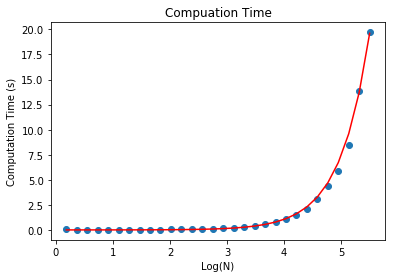

In [73]:
loglist=np.rint(np.logspace(1,5.5,base=10,num=30))
plt.scatter(np.array(range(1,len(times)+1))*5.5/30,times)
plt.plot(np.array(range(1,len(times)+1))*5.5/30,[6.2*(10**-5)*k for k in loglist],c='red')
plt.ylabel("Computation Time (s)")
plt.xlabel("Log(N)")
plt.title("Compuation Time")
# plt.plot()
plt.show()

In [75]:
score=[]
r2_score=[]
for k in np.rint(np.logspace(1,5.5,base=10,num=30)):
    gscv.fit(Xrand[:int(k)],Yrand[:int(k)])
#     print(k)
    score.append(rmse(X_test[test_mask],Y_test[test_mask],gscv))
    r2_score.append(gscv.best_score_)    

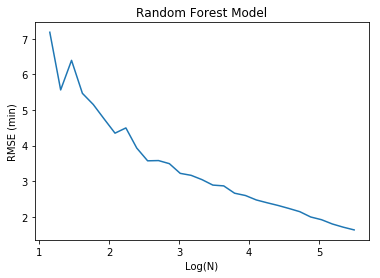

In [25]:
plt.plot(np.linspace(1,5.5,30)[1:],score[1:])
# plt.plot(np.linspace(1,5.5,100),[5 for _ in range(100)])
plt.xlabel("Log(N)")
plt.ylabel("RMSE (min)")
plt.title("Random Forest Model")
plt.show()

## IV. SigOpt Experiment

### Test Experiment

In [19]:
test_experiment=conn.experiments().create(
    name="Testing-ElasticNet",
    parameters=[
        dict(
            name="alpha",
            bounds=dict(
                min=.000001,
                max=1),
            type="double"),
        dict(
            name="l1_ratio",
            bounds=dict(
                min=0,
                max=100),
            type="double")],
#     metadata=dict(
#         template="python_sklearn_elasticnet"),    
        observation_budget=10)
    

print("Created experiment: https://sigopt.com/experiment/" + test_experiment.id)


def create_model_test(assignments):
    model = ElasticNet(
        alpha=assignments['alpha'],
        l1_ratio=assignments['l1_ratio'],
    ).fit(distance[train_mask], Y_train[train_mask])
    return model

def evaluate_model_test(assignments):
    model = create_model(assignments)
    return model.score(distance[test_mask], Y_test[test_mask])


for _ in range(test_experiment.observation_budget):
    suggestion = conn.experiments(test_experiment.id).suggestions().create()
    assignments = suggestion.assignments
    value = evaluate_model_test(assignments)

    conn.experiments(test_experiment.id).observations().create(
        suggestion=suggestion.id,
        value=value
    )
#     suggestion = conn.experiments(experiment.id).suggestions(suggestion.id).delete()

assignments = conn.experiments(test_experiment.id).best_assignments().fetch().data[0].assignments

print(assignments)

# This is a SigOpt-tuned model
test_experiment = create_model(assignments)

Created experiment: https://sigopt.com/experiment/54002


## Actual Experiment

In [52]:
experiment = conn.experiments().create(
  name="Random Forest Regresor 2.0 ",
  parameters=[
    dict(
      name="max_features",
      categorical_values=[
        dict(
          name="sqrt"
          ),
        dict(
          name="log2"
          )
        ],
      type="categorical"
      ),
    dict(
      name="max_depth",
      bounds=dict(
        min=3,
        max=30
        ),
      type="int"
      ),
    dict(
      name="criterion",
      categorical_values=[
        dict(
          name="mse"
          ),
        dict(
          name="mae"
          )
        ],
      type="categorical"
      ),
    dict(
      name="n_estimators",
      bounds=dict(
        min=10,
        max=100
        ),
      type="int"
      )
    ],
  metadata=dict(
    template="python_sklearn_randomforest"
    ),
  observation_budget=40
  )

print("Created experiment: https://sigopt.com/experiment/" + experiment.id)

Created experiment: https://sigopt.com/experiment/54026


In [12]:
new_parameters=[
    dict(
      name="max_features",
      categorical_values=[
        dict(
          name="sqrt"
          ),
        dict(
          name="log2"
          )
        ],
      type="categorical"
      ),
    dict(
      name="max_depth",
      bounds=dict(
        min=3,
        max=100
        ),
      type="int"
      ),
    dict(
      name="criterion",
      categorical_values=[
        dict(
          name="mse"
          ),
        dict(
          name="mae"
          )
        ],
      type="categorical"
      ),
    dict(
      name="n_estimators",
      bounds=dict(
        min=10,
        max=1000
        ),
      type="int"
      )
    ]

In [20]:
experiment=conn.experiments(54026).update(parameters=new_parameters)

In [21]:
def create_model(assignments):
    model = RandomForestRegressor(
        max_features=assignments['max_features'],
        max_depth=assignments['max_depth'],
        criterion=assignments['criterion'],
        n_estimators=assignments['n_estimators'],
    ).fit(Xrand[:20000], Yrand[:20000])
    return model

def evaluate_model(assignments):
    model = create_model(assignments)
    return model.score(X_test[test_mask], Y_test[test_mask])

# conn.set_api_url("https://api.sigopt.com")
# conn.experiments(53999).suggestions().create()
# suggestions_open = conn.experiments(53999).suggestions().fetch(
#   state="open"
#   )
# suggestion = conn.experiments(experiment.id).suggestions(21453053).delete()

In [22]:
score=[]
assignment_history=[]
for _ in range(20):
    suggestion = conn.experiments(54026).suggestions().create()
    assignments = suggestion.assignments
    assignment_history.append(assignments)
    value = evaluate_model(assignments)
    score.append(value)

    conn.experiments(54026).observations().create(
        suggestion=suggestion.id,
        value=value
    )
#     suggestion = conn.experiments(experiment.id).suggestions(suggestion.id).delete()

assignments = conn.experiments(54026).best_assignments().fetch().data[0].assignments

print(assignments)

# This is a SigOpt-tuned model
rf_regressor_v2 = create_model(assignments)

Assignments({
  "criterion": "mse",
  "max_depth": 57,
  "max_features": "log2",
  "n_estimators": 188
})


In [17]:
rmse(X_test[test_mask],Y_test[test_mask],rf_regressor_v2)

2.437094811267731

## V.  Intelligent Queries via Bayesian Optimization

We want to query the google travel-time matrix as intelligently as possible so that we can build a model with as little data as possible.  This is very similar to the kind of problem discussed in "Information Collection On A Graph" by Ryzhov and Powell.  One crucial difference is that they were interested in finding the best path after collecting data.  For their purposes, the values of each link are fixed but unknown.  However, for the app that we would like to build, we need to be prepared to serve many different users who might value the individual links differently.  Given the complexity of actually evaluating a route score, the problems getting the data and evaluating the score need to be effectively decoupled.  Thus, what we want is simply a good model of the travel-time matrix and our goal is to query the Google API so that we achieve a good model as quickly as possible.  It is not immediately obvious what the best way to achieve this goal is.  

In the crude test below, we try out a KG motivated strategy for querying the Google API.  In the present case, the data we have already collected will serve as a stand-in for the google data we would ultimately be querying.  We roughly follow https://arxiv.org/pdf/1807.02811.pdf, where we update according to equation (3).  We choose a very simplistic method for evaluating the next poing - we merely pick the point with the highest variance at each stage.  We could probably do much better with a little more thought (and reading) but this was a useful first pass.

## Kernel

In choosing a kernel we are asked to estimate how much one travel time should influence our knowledge of a second travel time.  It is reasonable to assume that if two places are within walking distance, e.g., half a mile, then the travel times are highly correlated.  We thus want something like a guassian kernel with a half-mile standard deviation.  First, we need to form a good notion of distance between two paths.  For the sake of argument, I'll use the following:

In [76]:
def path_distance_squared(path1,path2):
    path1=path1.reshape(-1,4)
    path2=path2.reshape(-1,4)
    d11_squared=make_distance(np.concatenate((path1[:,:2],path2[:,:2]),axis=1))
    d12_squared=make_distance(np.concatenate((path1[:,:2],path2[:,2:]),axis=1))
    d21_squared=make_distance(np.concatenate((path1[:,2:],path2[:,:2]),axis=1))
    d22_squared=make_distance(np.concatenate((path1[:,2:],path2[:,2:]),axis=1))
    res1=d11_squared+d22_squared
    res2=d12_squared+d21_squared
    return res1*res2/(res1+res2)

This metric has the property that it is smaller when the endpoints of the two paths approach one another and it is agnostic about the orientation of the path (as it should be).  Next, we define a kernel as:

In [77]:
def S(x1,x2,alpha=.1,sigma=.5):
    return alpha*np.exp(-path_distance_squared(x1,x2)/(2*sigma**2))


Now let's define the important stuff.  We have to do the query one step at a time based upon the data currently available.  This is actually infuriatingly slow, though I haven't really optimzed for speed yet.  (The arcos operation is slow, though this could be done away with if we are willing to settle for Euclidean approximations for the distance.  This would be fine as long as we are in San Francisco and not on an international flight, but it is a bit unsatisfying.  I should also do a better job of constructing the matrix and doing matrix inversin.  Oh well, this will be something to get right on the next pass.)

In [85]:
def mu0(x):
    return coef*make_distance(x)

## 'make_matrix' produces a matrix from the kernel and should be identified with 
##  Sigma_0 in https://arxiv.org/pdf/1807.02811.pdf.

def make_matrix(data_X,S):
    matrix=np.zeros((len(data_X),len(data_X)))
    for i in range(len(data_X)):
        for j in range(len(data_X)):
            matrix[i][j]=S(data_X[i],data_X[j])
    return matrix

def make_vec(S,current_X,X):
    array=[]
    for x in X:
        row=[]
        for y in current_X:
            row.append(S(x,y))
        array.append(np.nan_to_num(np.array(row)))
    return np.vstack(array).reshape(len(array),-1)

I am going to run this algorithm on a very small dataset because this is very slow.  I hope to improve this soon.

In [86]:
shuffle=np.random.permutation(len(X))
X_rand=X[shuffle][:1000]
Y_rand=Y[shuffle][:1000]
X_rand_test=X_rand[-100:]
Y_rand_test=Y_rand[-100:]
full=np.nan_to_num(make_matrix(X_rand,S))


rf=RandomForestRegressor()

/Users/williamcottrell72/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in arccos
  # This is added back by InteractiveShellApp.init_path()
/Users/williamcottrell72/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


In [90]:
bayes_score=[]
naive_score=[]
current_X=X_rand[:10]
current_Y=Y_rand[:10]

for k in range(200):

    matrix=np.nan_to_num(make_matrix(current_X,S))
    try:
        inv=np.linalg.inv(matrix)
    except:
        break
    vec=make_vec(S,current_X,X_rand)


    sigma_squared=[]
    for i in range(100):
        s2=full[i][i]-np.dot(vec[i],np.dot(inv,vec.T))[i]
        sigma_squared.append(s2)

    ind=np.argmax(sigma_squared)

    current_X=np.nan_to_num(np.concatenate((current_X,X_rand[ind].reshape(1,-1)),axis=0))
    current_Y=np.nan_to_num(np.concatenate((current_Y.reshape(-1,1),Y_rand[ind].reshape(1,-1)),axis=0))
    naive_current_X=np.nan_to_num(X_rand[:11+k])
    naive_current_Y=np.nan_to_num(Y_rand[:11+k])
    
    rf.fit(current_X,current_Y)
    bayes_score.append(rf.score(X_rand_test,Y_rand_test))
    
    rf.fit(naive_current_X,naive_current_Y)
    naive_score.append(rf.score(X_rand_test,Y_rand_test))
    
    
    print(k,len(current_X))

0 11
1 12
2 13
3 14
4 15
5 16
6 17
7 18
8 19
9 20
10 21
11 22
12 23
13 24
14 25
15 26
16 27
17 28
18 29
19 30
20 31
21 32
22 33
23 34
24 35
25 36
26 37
27 38
28 39
29 40
30 41
31 42
32 43
33 44
34 45
35 46
36 47
37 48
38 49
39 50
40 51
41 52
42 53
43 54
44 55
45 56
46 57
47 58
48 59
49 60
50 61
51 62
52 63
53 64
54 65
55 66
56 67
57 68
58 69
59 70
60 71
61 72
62 73
63 74
64 75
65 76
66 77
67 78
68 79
69 80
70 81
71 82
72 83
73 84
74 85
75 86
76 87
77 88
78 89


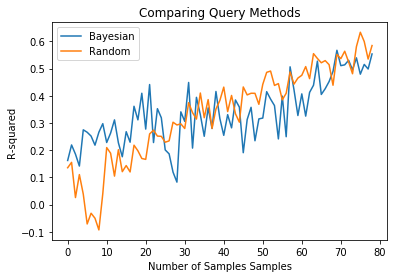

In [91]:
plt.plot(range(len(bayes_score)),bayes_score,label="Bayesian")
plt.plot(range(len(bayes_score)),naive_score,label="Random")
plt.xlabel("Number of Samples Samples")
plt.ylabel("R-squared")
plt.title("Comparing Query Methods")
plt.legend()
plt.show()

This plot is not very conclusive.  All one can say is that the Bayesian or 'Knowledge Gradient' method did not clearly beat random sampling, in fact, it appears to be loosing as the data set gets larger.  This may be because the random sample more closely reflects the distribution of the whole population and that is what's ultimately more important for buliding a good model.  Still, it would be interesting to explore more sophisticated Bayesian methods of sampling using more data and with faster, more optimized algorithms.  This is work in progress.